<a href="https://colab.research.google.com/github/mshilpaa/Deep-Neural-Network/blob/master/Assignment%205/PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/My Drive/HVC_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: drive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os

In [29]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


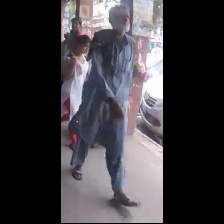

In [30]:
from PIL import Image
img = Image.open(df['image_path'][100])
img

In [34]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [36]:
one_hot_df.shape  

(13573, 28)

In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]


In [0]:
def get_random_eraser(p=0.5, s_l=0.01, s_h=0.2, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False),
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [0]:
import keras
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, aug=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.aug = aug

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        if self.aug is not None:
          image = next(self.aug.flow(image,shuffle=True))
   
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
subtract_pixel_mean = True
for i in range(len(one_hot_df)):
  train_img = np.array(Image.open(one_hot_df['image_path'][i]))
  train_img = train_img.astype('float32') / 255
 

  # If subtract pixel mean is enabled
  if subtract_pixel_mean:
      train_df_mean = np.mean(Image.open(one_hot_df['image_path'][i]), axis=0)
      train_img -= train_df_mean
   

In [43]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,shuffle=True)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [44]:
train_df['image_path']

6673      resized/6674.jpg
6480      resized/6481.jpg
7386      resized/7387.jpg
12493    resized/12495.jpg
5411      resized/5412.jpg
               ...        
4714      resized/4715.jpg
8850      resized/8851.jpg
10576    resized/10578.jpg
1160      resized/1161.jpg
5545      resized/5546.jpg
Name: image_path, Length: 11537, dtype: object

In [45]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
6673,resized/6674.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
6480,resized/6481.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
7386,resized/7387.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
12493,resized/12495.jpg,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
5411,resized/5412.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,aug=datagen)
valid_gen = PersonDataGenerator(val_df, batch_size=64)

In [47]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
from keras.models import Sequential
from keras.layers import Activation,BatchNormalization,Dropout,Convolution2D,MaxPooling2D

In [52]:
backbone = Sequential()

backbone.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(224,224,3), use_bias=False)) #222
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False)) #220
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(128, 1, 1, activation='relu', use_bias=False)) #218

backbone.add(MaxPooling2D(pool_size=(2, 2)))

backbone.add(Convolution2D(256, 3, 3, activation='relu', use_bias=False))#108
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(128, 3, 3, activation='relu', use_bias=False))#106
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(128, 3, 3, activation='relu', use_bias=False))#104
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False))#102
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False))#100
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(MaxPooling2D(pool_size=(2, 2)))

backbone.add(Convolution2D(128, 3, 3, activation='relu', use_bias=False))#50
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(128, 3, 3, activation='relu', use_bias=False))#48
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False))#46
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False))#44
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(MaxPooling2D(pool_size=(2, 2)))

backbone.add(Convolution2D(128, 3, 3, activation='relu', use_bias=False))#22
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(128, 3, 3, activation='relu', use_bias=False))#20
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False))#18
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))

backbone.add(Convolution2D(64, 3, 3, activation='relu', use_bias=False))#16
backbone.add(BatchNormalization())
backbone.add(Dropout(0.1))


backbone.add(Convolution2D(10, 4, 4))# 14

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.15)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224,..., use_bias=False)`
  This is separate from the ipykernel package so we can avoid doing imports until







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", use_bias=False)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), activation="relu", use_bias=False)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", use_bias=False)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", us

In [0]:
def lr_schedule(epoch, lr):
  l_rate = round(0.003 * 1/(1 + 0.319 * epoch), 10)
  print('Learning rate: ', l_rate)
  return l_rate

In [58]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
 "emotion_output":  "categorical_crossentropy",
 "footwear_output":  "categorical_crossentropy",
 "pose_output":  "categorical_crossentropy",


}
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.1, momentum=0.9)
model.compile(
    optimizer=opt,
    loss=losses, 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


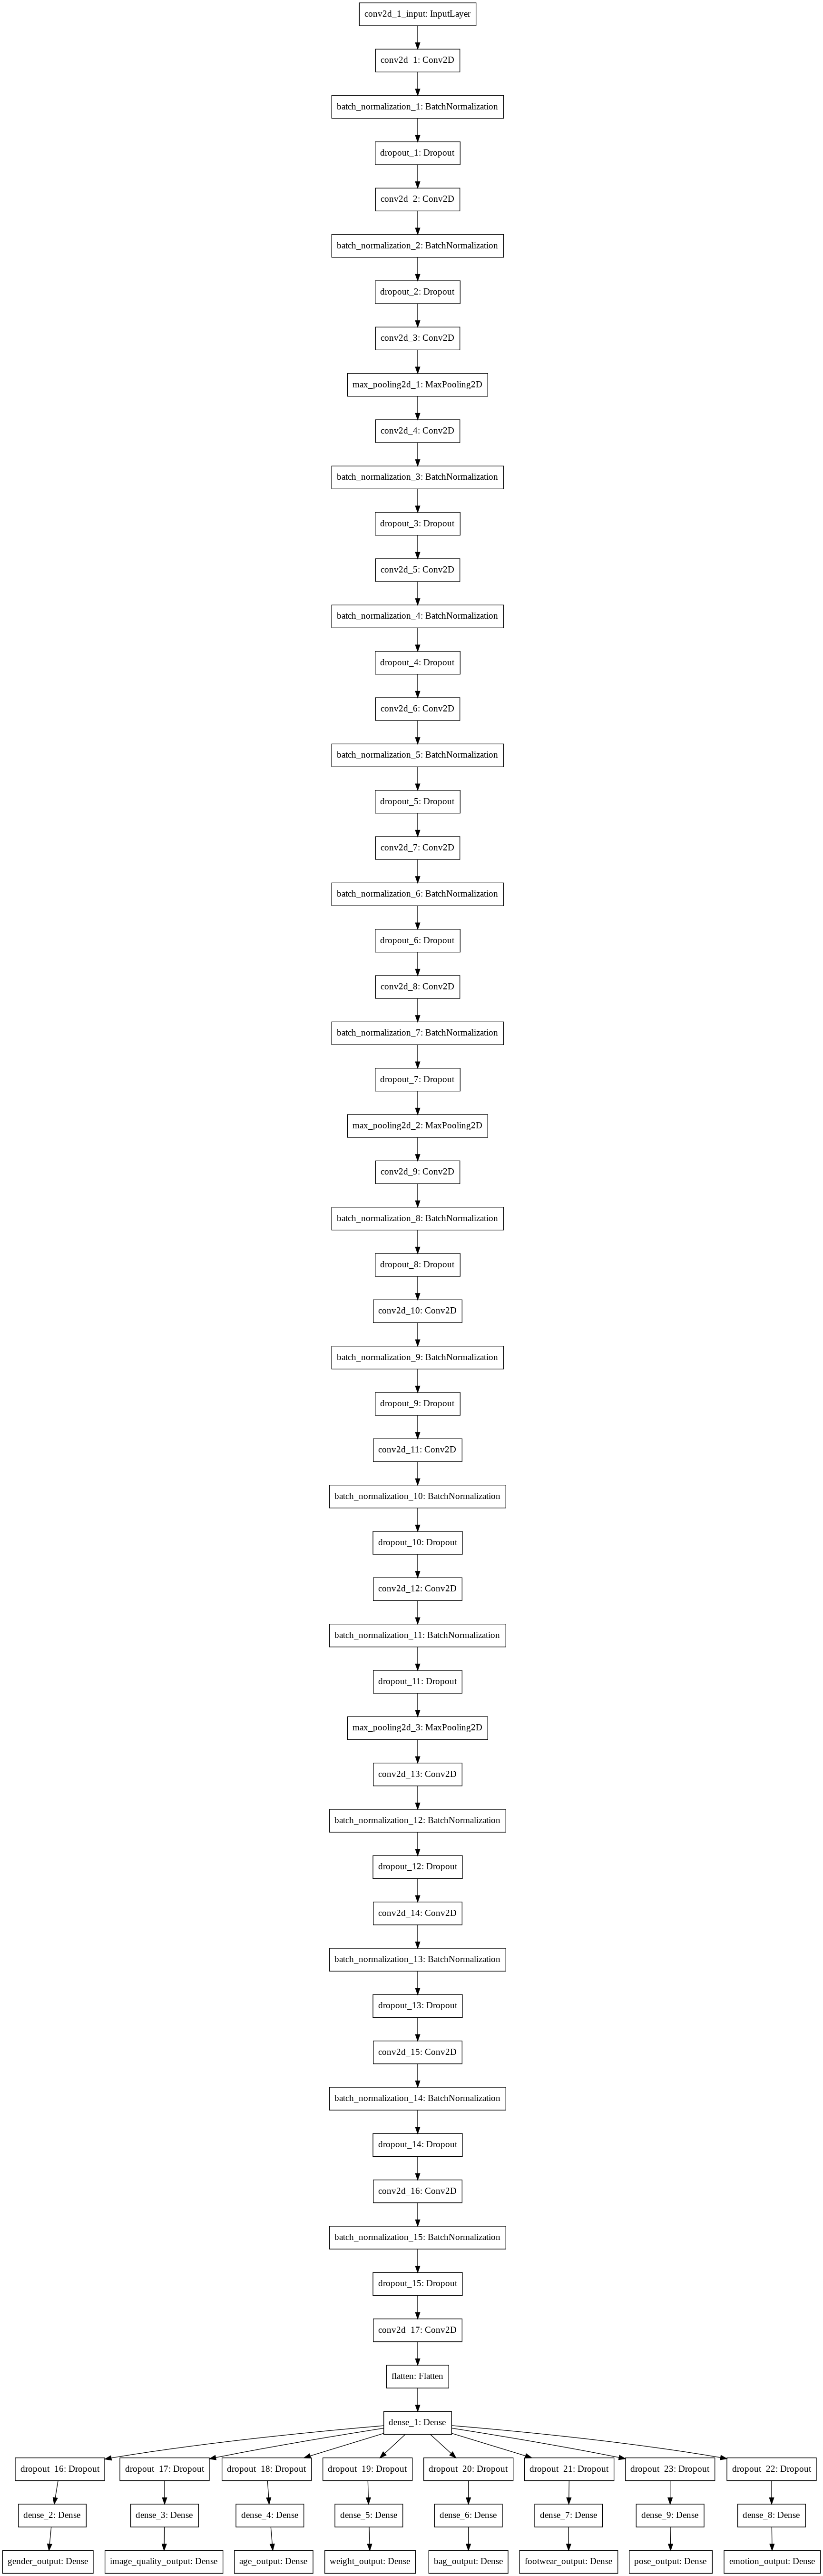

In [59]:
from keras.utils import plot_model
plot_model(model)

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'person_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True,
                             save_weights_only = False)

gender_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'gender_checkpoint.h5'),
                             monitor='val_gender_output_acc',
                             verbose=1,
                             save_best_only=True)
imgQuality_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'imgQuality_checkpoint.h5'),
                             monitor='val_image_quality_output_acc',
                             verbose=1,
                             save_best_only=True)
age_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'age_checkpoint.h5'),
                             monitor='val_age_output_acc',
                             verbose=1,
                             save_best_only=True)
weight_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'weight_checkpoint.h5'),
                             monitor='val_weight_output_acc',
                             verbose=1,
                             save_best_only=True)
bag_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'bag_checkpoint.h5'),
                             monitor='val_bag_output_acc',
                             verbose=1,
                             save_best_only=True)
footwear_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'gender_checkpoint.h5'),
                             monitor='val_footwear_output_acc',
                             verbose=1,
                             save_best_only=True)
pose_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'pose_checkpoint.h5'),
                             monitor='val_pose_output_acc',
                             verbose=1,
                             save_best_only=True)
emotion_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'emotion_checkpoint.h5'),
                             monitor='val_emotion_output_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint,gender_checkpoint,imgQuality_checkpoint,age_checkpoint,weight_checkpoint,bag_checkpoint,footwear_checkpoint,pose_checkpoint,emotion_checkpoint, LearningRateScheduler(lr_schedule, verbose=1)]

In [63]:

model_info=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=100,
    verbose=1,
    callbacks=callbacks
)
# plot_model_history(model_info)



Epoch 1/100
Learning rate:  0.003

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
360/360 [==============================] - 176s 488ms/step - loss: 8.6049 - gender_output_loss: 0.7472 - image_quality_output_loss: 1.0685 - age_output_loss: 1.5531 - weight_output_loss: 1.0734 - bag_output_loss: 1.0015 - footwear_output_loss: 1.1360 - pose_output_loss: 1.0104 - emotion_output_loss: 1.0147 - gender_output_acc: 0.5383 - image_quality_output_acc: 0.5292 - age_output_acc: 0.3620 - weight_output_acc: 0.6213 - bag_output_acc: 0.5320 - footwear_output_acc: 0.4159 - pose_output_acc: 0.5956 - emotion_output_acc: 0.7002 - val_loss: 8.7909 - val_gender_output_loss: 0.7209 - val_image_quality_output_loss: 1.0952 - val_age_output_loss: 1.5914 - val_weight_output_loss: 1.2585 - val_bag_output_loss: 0.9519 - val_footwear_output_loss: 1.0721 - val_pose_output_loss: 1.0149 - val_emotion_output_loss: 1.0859 - val_gender_output_acc: 0.5363 - val_image_quality_output_acc: 0.5257 - val_